# Notebook Overview
## Goal
* As we wanted our results to be comparable with the bag-of-words model, in this notebook, we applied the best TF-IDF clustering configuration (K-means clustering with random starts, cosine metric and six clusters). 
* To come back to the data preprocessing set up used in the previous method, we aggregated all chunks of tweets from each author and used a majority vote to assign them to a specific cluster. 
* We evaluated the performance of this configuration using the purity and slhouette score. Based on those metrics, vectors generated by SBERT lead to higher quality clusters than the ones generated using TF-IDF. In terms of silhouette score, the clusters are denser and better separated in the dense vector configuration than using sparse vectors. It suggests a higher quality of clusters (better cohesion and separation). 
* In terms of purity, there is 6 points difference between the SBERT configuration and the TFIDF one. It suggests that the contextualized word representations generated by SBERT correlates better with the labels of our dataset (without any fine-tuning). 
* The embeddings generated by SBERT cannot directly be used to interpret the different clusters. To create word cloud visualizations, we transformed the tweets into a bag-of-words model with TF-IDF frequencies and then applied the methodology described in section 2 (using the newly generated clusters). Figure y shows the word cloud visualizations generated using the SBERT configuration. 


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [ ]:
!pip install umap-learn
!pip install transformers

import umap.umap_ as umap
import pandas as pd
import numpy as np
from statistics import mean

import torch
import torch.nn as nn

from nltk.cluster import KMeansClusterer, cosine_distance

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as pl

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer


import os
from collections import defaultdict

from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestCentroid
from scipy.stats import stats
from pandas import DataFrame
import re
import nltk
nltk.download('wordnet')

# Utility functions

In [ ]:
def average_silhouette(embedding : list, n_clusters: int = 5):
    """ 
    Use KMeans to cluster the embedding and then compute the average
    silhouette score.
    
    Args:
    -------------
    embedding: sentence embedding from bert
    n_clusters: the number of clusters you want to split your data in
    
    Returns:
    -------------
    model.score: score of the KMeans model
    cluster_labels : numpy array of labels
    """
    model_scores = [] 
    model_silhouettes = []

    model = KMeansClusterer(n_clusters, distance=cosine_distance,repeats=25, avoid_empty_clusters=True)
    cluster_labels = model.cluster(embedding, assign_clusters=True)

    silhouette_avg = silhouette_score(embedding, cluster_labels)
    print(f'Avg silhouette score is {silhouette_avg}')

    return model, cluster_labels

In [ ]:
# performance metrics
def purity_silhouette(data: pd.DataFrame, cluster_labels : list ,true_labels: list):
  """
  Returns a table with the purity and silhouette score of each cluster. It is used to evaluate the performance of our clustering.

  Args:
  ------------
  data: DataFrame of the features used to amke the clustering. In our case the umap vectors.
  cluster_labels: labels assigned by KMeans to each sample (predictions)
  true_labels: real labels for each sample (target)

  Returns:
  ------------
  DataFrame with 2 rows and k columns (k corresponding to the number of clusters). The first row shows the silhouette score, and the second purity. 
  """
  sil=silhouette_samples(data, cluster_labels)
  silbycluster=[]
  purbycluster=[]
  for i in np.unique(cluster_labels):
      silbycluster.append(np.mean(sil[cluster_labels==i]))
      purbycluster.append(purity_score(np.array(true_labels)[cluster_labels==i],cluster_labels[cluster_labels==i]))
  silbycluster = np.round(np.array(silbycluster),2)
  purbycluster = np.round(np.array(purbycluster),2)
  return(pd.DataFrame([silbycluster,purbycluster], index=["silhouette","purity"]))

In [ ]:
def plot_top_n_words(top_n_words: dict, n: int):
  """
  Simple function to print the top n words of a cluster based on
  c-TF-IDF, a notion introduced in BERTopics.

  Args:
  --------
  top_n_words : dictionary with key the clusters and values a list of words
  n : the number of words you want to print for each cluster

  Returns:
  --------
  Nothing
  """
  for cluster in range(6):
    print(f"Cluster number {cluster} topic:")
    print(top_n_words[cluster][:n])
    print("\n")

In [ ]:
# Code taken from https://github.com/KIZI/evaluation-of-comprehensibility/blob/master/clustering_analysis_v2/LINVILLWARREN-AlternativeA-full.ipynb.ipynb
def contingencytable (data, cluster_labels,true_labels):
    colors = ["blue","pink","black","green","yellow","violet","red","grey"]

    df = pd.DataFrame({'cluster': cluster_labels,
                       'category': true_labels})
    newdf = df.groupby(by=["cluster","category"]).size().unstack().reset_index().drop("cluster",axis=1)
    newdf = newdf.rename_axis("cluster",axis="columns")
    ax = newdf.plot.bar(stacked=True,color=colors)
    ax.set_ylabel("account count")
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
       
# Code taken from https://github.com/KIZI/evaluation-of-comprehensibility/blob/master/clustering_analysis_v2/LINVILLWARREN-AlternativeA-full.ipynb.ipynb
def purity_silhouette(data,cluster_labels,true_labels):
    sil=silhouette_samples(data, cluster_labels)
    silbycluster=[]
    purbycluster=[]
    for i in np.unique(cluster_labels):
        silbycluster.append(np.mean(sil[cluster_labels==i]))
        purbycluster.append(purity_score(np.array(true_labels)[cluster_labels==i],cluster_labels[cluster_labels==i]))
    silbycluster     = np.round(np.array(silbycluster),2)
    purbycluster     = np.round(np.array(purbycluster),2)
    return(pd.DataFrame([silbycluster,purbycluster], index=["silhouette","purity"]))

# Code taken from https://github.com/KIZI/evaluation-of-comprehensibility/blob/master/clustering_analysis_v2/LINVILLWARREN-AlternativeA-full.ipynb.ipynb
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [1]:
# functions used to create the wordcloud visualizations
def top_terms(df, top_n=5):
    return df.sum().sort_values(ascending=False).head(top_n)

def dfFromModel(model,vectorizer, doc_term_matrix, clusters):
    
    dataframe = DataFrame(doc_term_matrix.todense(),columns=vectorizer.get_feature_names())
    dataframe["labels"] = cluster_labels

    return dataframe.groupby('labels').mean()

def dfFromModel_Zscore(cluster_centers, transformation = None):
    if transformation == None:
        transformed=cluster_centers
    elif transformation=="zscore" or  transformation=="zscore_rescaled":
        zscore=stats.zscore(cluster_centers, axis=0)
        if transformation=="zscore_rescaled":
            #data are flattened into one long vector
            zscore_flattened = zscore.reshape(zscore.shape[0] * zscore.shape[1], 1)
            #rescaled
            #MinMaxScaler preserves the shape of the original distribution.
            scaler = MinMaxScaler((0,100))
            # find maximum absolute z score 
            bound = max(max(zscore_flattened), abs(min(zscore_flattened)))
            # use the maximum z score to create transformation centered around 0
            scaler.fit(np.array([-bound,bound]))
            #scaler.fit(zscore_flattened) # originaly the transformation was fitted without the centering
            #owing to the centering, after the transformation, value 50 corresponds to zscore 0 
            zscore_flattened_scaled = scaler.transform(zscore_flattened)
            #and transformed back to the original shape
            zscore_scaled = zscore_flattened_scaled.reshape(zscore.shape[0], zscore.shape[1])
            transformed=zscore_scaled
        else:
            transformed=zscore
    dataframe = DataFrame(transformed, columns=vectorizer.get_feature_names())
    return(dataframe)

In [ ]:
# Code modified from https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


In [ ]:
# this function is used both for standard word clouds and z-score word clouds
def wordcloud(dataframe, path, spectral=False, max_words=200,vertical =1,  horizontal =6):
    if dataframe.shape[0] == 5:
        vertical =1
        horizontal =5
    
    clusters_word_freq = []

    for index, row in dataframe.iterrows():
        freq_dict = {}
        for col_name in dataframe.columns:
            if row[col_name] > 0.00001:
                freq_dict[col_name] = float(row[col_name])
        clusters_word_freq.append(freq_dict)

    fig = pl.figure(figsize=(20, 10))
    for cluster, freq_dict in enumerate(clusters_word_freq):
        if spectral: #used for wordclouds from zscores, coolwarm goes from blue to red 
            def color_func(word, *args, **kwargs):
                cmap = pl.cm.get_cmap('coolwarm')
                #Colormap instances are used to convert data values (floats) from the interval [0, 1] to the RGBA color
                rgb = cmap(freq_dict[word] / 100, bytes=True)[0:3]                    
                return rgb
        else:
            color_func = None

        ax = fig.add_subplot(vertical, horizontal, cluster + 1)
        cloud = WordCloud(normalize_plurals=False,
                          background_color='white', color_func=color_func,max_words=max_words, random_state=42)
        cloud.generate_from_frequencies(frequencies=freq_dict)
        ax.imshow(cloud, interpolation='bilinear')
        ax.set_yticks([])
        ax.set_xticks([])
        ax.text(0.35, 1, f'Cluster {cluster}',
                 fontsize=32, va='bottom',transform=ax.transAxes)
    fig.show()
    ax.figure.savefig(path+'.pdf',bbox_inches='tight')

In [ ]:
# Code taken from https://github.com/KIZI/evaluation-of-comprehensibility/blob/master/clustering_analysis_v2/LINVILLWARREN-AlternativeA-full.ipynb.ipynb
class TrollTfidfVectorizer(TfidfVectorizer):
    def __init__(self, *args, **kwargs):
        troll_stop_words = {'don', 'just', 'like'} # the custom stop word list could be further expanded
        kwargs['stop_words'] = set(ENGLISH_STOP_WORDS).union(troll_stop_words)
        kwargs['preprocessor'] = self.vectorizer_preprocess
        self.wnl = WordNetLemmatizer()
        super(TrollTfidfVectorizer, self).__init__(*args, **kwargs)

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: ([self.wnl.lemmatize(w) for w in analyzer(doc)])

    def vectorizer_preprocess(self, s):
        # remove urls
        s = re.sub(r'(https?|ftp)://(-\.)?([^\s/?\.#-]+\.?)+(/[^\s]*)?', '', s)
        # remove amp
        s = s.replace('&amp;', '')
        # remove RT signs (no meaning) but keep username
        s = re.sub(r'\bRT\b\s+', '', s)
        s = s.lower()
        return s

# Data loading

In [ ]:
dataset_to_process = "MANNHEIM"
MAX_WORDS_WORDCLOUD =100
# load the dataset that contains the tweets, the labels and their readability feature.
# df = pd.read_csv("100_tweets_explode.csv")
# # load the embedding
# emb = torch.load("100_embeddings_explode.pt")
df = pd.read_csv("Full_tweets_explode.csv")
df = df.drop("readability",axis=1)
# load the embedding
emb = torch.load("Full_embeddings_explode.pt")
print(df.shape)
print(emb.shape)
df.head()

/content/drive/My Drive/Research Assistant/Paper
(105948, 5)
(105948, 768)


,Unnamed: 0,authors,Tweets,Labels,tweet_len
0,0,10_GOP,Sad day when buildings get boarded up and the ...,RightTroll,23
1,0,10_GOP,know that we Americans are first on your list....,RightTroll,23
2,0,10_GOP,After the 'genocide' remark from San Juan Mayo...,RightTroll,23
3,0,10_GOP,https://t.co/czutyGaMQV ISIS says multiple att...,RightTroll,23
4,0,10_GOP,#1A https://t.co/IlTA3yc8df All of the good gu...,RightTroll,23


# Lower the dimensionality of the embeddings as vanilla KMeans cannot handle high dimensionality data

We will use UMAP because it keeps a significant portion of the high-dimensional local structure in lower dimensionality. It is often used after sentence-bert.

* It seems that decreasing min_distance decreases the purity score but increases the average silhouette score.

In [ ]:
# this cell will take time to execute completely (1-3 minutes)
umap_embeddings = umap.UMAP(n_components= 4,
                            n_neighbors=15,
                            random_state = 42,
                            min_dist = 0.01,
                            metric='cosine').fit_transform(emb)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


CPU times: user 4min 33s, sys: 24.9 s, total: 4min 58s
Wall time: 3min 7s


In [ ]:
# Display the average silhouette score
model, cluster_labels = average_silhouette(umap_embeddings)

Avg silhouette score is 0.470747172832489


In [ ]:
# Assign a label to each chunk of tweets
df["cluster_labels"] = cluster_labels

In [ ]:
# extract umap features
umap_df = pd.DataFrame(umap_embeddings)
df = pd.concat([df,umap_df],axis=1)

In [ ]:
# show the dataset
df.columns = ["index",	"authors",	"Tweets",	"Labels",	"tweet_len", "cluster_labels", "umap1", "umap2", "umap3", "umap4"	]
df.head()

,index,authors,Tweets,Labels,tweet_len,cluster_labels,umap1,umap2,umap3,umap4
0,0,10_GOP,Sad day when buildings get boarded up and the ...,RightTroll,23,3,2.900290,9.768094,9.845039,-2.173289
1,0,10_GOP,know that we Americans are first on your list....,RightTroll,23,3,2.056457,8.945681,9.808987,-1.828724
2,0,10_GOP,After the 'genocide' remark from San Juan Mayo...,RightTroll,23,3,2.230618,9.375346,10.974777,-2.646329
3,0,10_GOP,https://t.co/czutyGaMQV ISIS says multiple att...,RightTroll,23,3,2.213581,8.765841,9.345916,-1.407864
4,0,10_GOP,#1A https://t.co/IlTA3yc8df All of the good gu...,RightTroll,23,3,2.224939,8.693519,9.851776,-2.098060


## Aggregation step
* Now that each chunk of tweet is assigned to a specific cluster, we need to aggregate all the tweets to come back to the setting we used for the TF-IDF configuration (we want to cluster all the tweets from the same author under the same label). 
* We aggregate all the chunk of tweets on the author level.

In [ ]:
aggregation = df.groupby("authors").agg({"cluster_labels":lambda x:x.value_counts().index[0], "Labels": lambda x:x.value_counts().index[0], "Tweets": lambda x: " ".join(x), "umap1": lambda x: np.mean(x), "umap2": lambda x: np.mean(x), "umap3": lambda x: np.mean(x), "umap4": lambda x: np.mean(x)}).reset_index()
aggregation.head()

,authors,cluster_labels,Labels,Tweets,umap1,umap2,umap3,umap4
0,10_GOP,3,RightTroll,Sad day when buildings get boarded up and the ...,2.212834,8.994882,10.080130,-2.037911
1,4MYSQUAD,2,LeftTroll,'@Drake YASSS' '@CockJakeWatson @hannibalbures...,1.011006,11.040719,7.773379,-1.093380
2,AANTIRACIST,2,LeftTroll,Ditto https://t.co/bwG01v9ZQX No one ever gets...,0.258670,10.089948,8.996461,-1.095737
3,ABIGAILSSILK,1,HashtagGamer,#MyOlympicSportWouldBe jumping to the worst po...,-2.376535,7.755336,3.874241,2.941710
4,ABIISSROSB,3,RightTroll,#abi Charlottesville Police Stood Down When Th...,2.290078,9.425114,10.329405,-2.305860


In [ ]:
# Display clustering performance
purity_silhouette(aggregation[["umap1","umap2","umap3", "umap4"]].values, aggregation.cluster_labels, aggregation.Labels)

,0,1,2,3,4
silhouette,0.93,0.50,0.57,0.41,0.36
purity,1.00,0.68,0.93,0.88,0.67


In [ ]:
# compute the average purity across the different clusters
cluster_labels = aggregation.cluster_labels
true_labels = aggregation.Labels
purbycluster=[]
for i in np.unique(cluster_labels):
  purbycluster.append(purity_score(np.array(true_labels)[cluster_labels==i],cluster_labels[cluster_labels==i]))

purbycluster = np.round(np.array(purbycluster),2)
np.mean(purbycluster)

0.8320000000000001

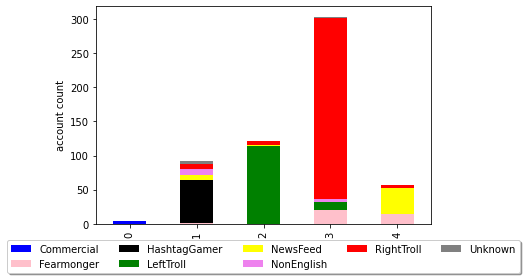

In [ ]:
contingencytable(aggregation, aggregation.cluster_labels.values, aggregation.Labels.values)

## Data Visualization
* This part of the notebook aims at creating the two type of wordclouds that we described in our paper. 
* The embeddings generated by SBERT cannot directly be used to interpret the different clusters. To create word cloud visualizations, we transformed the tweets into a bag-of-words model with TF-IDF frequencies and then applied the methodology described in section 2 of the paper (using the newly generated clusters).

In [ ]:
MIN_DF = 0.4 #as in the original experiment for user study
MAX_FEATURES= 100 # as in the notebook https://github.com/KIZI/evaluation-of-comprehensibility/blob/master/clustering_analysis_v2/LINVILLWARREN-AlternativeB-full-100features.ipynb

vectorizer = TrollTfidfVectorizer(max_features=MAX_FEATURES, min_df=MIN_DF)
doc_term_matrix = vectorizer.fit_transform(aggregation.Tweets.values)
doc_term_matrix

<578x100 sparse matrix of type '<class 'numpy.float64'>'
	with 50591 stored elements in Compressed Sparse Row format>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


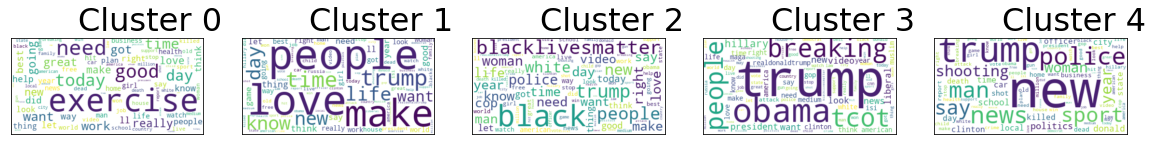

In [ ]:
# wordclouds from average values.
wordcloud(dfFromModel(model,vectorizer, doc_term_matrix, cluster_labels),"wordclouds_"+dataset_to_process + "_INTERNAL",max_words=MAX_WORDS_WORDCLOUD)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


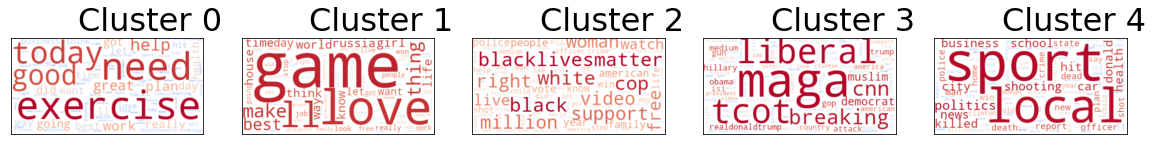

In [ ]:
# wordclouds from z-scores
features = pd.DataFrame(doc_term_matrix.toarray())
aggregation = pd.concat([aggregation, features],axis=1)
aggregation = aggregation.groupby("cluster_labels").mean().reset_index(drop = True)

wordcloud(dfFromModel_Zscore(aggregation.drop(["umap1","umap2","umap3","umap4"],axis=1).values.tolist(),"zscore_rescaled"),"wordclouds_z_"+dataset_to_process+"_INTERNAL", spectral=True,max_words=MAX_WORDS_WORDCLOUD)